In [ ]:
import tensorflow as tf

In [ ]:
from keras.applications import inception_v3
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

Instructions for updating:
Colocations handled automatically by placer.
87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
#model.summary()

Next, we compute the "loss", the quantity that we will seek to maximize during the gradient ascent process. In Chapter 5, for filter visualization, we were trying to maximize the value of a specific filter in a specific layer. Here we will simultaneously maximize the activation of all filters in a number of layers. Specifically, we will maximize a weighted sum of the L2 norm of the activations of a set of high-level layers. The exact set of layers we pick (as well as their contribution to the final loss) has a large influence on the visuals that we will be able to produce, so we want to make these parameters easily configurable. Lower layers result in geometric patterns, while higher layers result in visuals in which you can recognize some classes from ImageNet (e.g. birds or dogs). We'll start from a somewhat arbitrary configuration involving four layers -- but you will definitely want to explore many different configurations later on:

In [ ]:
# Dict mapping layer names to a coefficient
# quantifying how much the layer's activation
# will contribute to the loss we will seek to maximize.
# Note that these are layer names as they appear
# in the built-in InceptionV3 application.
# You can list all layer names using `model.summary()`.
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

Now let's define a tensor that contains our loss, i.e. the weighted sum of the L2 norm of the activations of the layers listed above.

In [ ]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

Now we can set up the gradient ascent process:

In [ ]:
# This holds our generated image
dream = model.input

# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]

# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

Finally, here is the actual Deep Dream algorithm.

First, we define a list of "scales" (also called "octaves") at which we will process the images. Each successive scale is larger than previous one by a factor 1.4 (i.e. 40% larger): we start by processing a small image and we increasingly upscale it:

image.png

Then, for each successive scale, from the smallest to the largest, we run gradient ascent to maximize the loss we have previously defined, at that scale. After each gradient ascent run, we upscale the resulting image by 40%.

To avoid losing a lot of image detail after each successive upscaling (resulting in increasingly blurry or pixelated images), we leverage a simple trick: after each upscaling, we reinject the lost details back into the image, which is possible since we know what the original image should look like at the larger scale. Given a small image S and a larger image size L, we can compute the difference between the original image (assumed larger than L) resized to size L and the original resized to size S -- this difference quantifies the details lost when going from S to L.

The code above below leverages the following straightforward auxiliary Numpy functions, which all do just as their name suggests. They 
require to have SciPy installed.

In [ ]:
import scipy
import imageio
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imwrite(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.

# Fill this to the path to the image you want to use
base_image_path = '/content/drive/MyDrive/cat and dog/test/cat/cat.3506.jpg'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

Processing image shape (162, 255)
...Loss value at 0 : 1.1867259
...Loss value at 1 : 1.6901355
...Loss value at 2 : 2.44409
...Loss value at 3 : 3.1225681
...Loss value at 4 : 3.7048283
...Loss value at 5 : 4.350521
...Loss value at 6 : 4.8151164
...Loss value at 7 : 5.3841496
...Loss value at 8 : 5.760319
...Loss value at 9 : 6.2679377
...Loss value at 10 : 6.764702
...Loss value at 11 : 7.2113333
...Loss value at 12 : 7.663713
...Loss value at 13 : 7.9489794
...Loss value at 14 : 8.322533
...Loss value at 15 : 8.648253
...Loss value at 16 : 9.097131
...Loss value at 17 : 9.412959
...Loss value at 18 : 9.707999
Processing image shape (227, 357)
...Loss value at 0 : 2.6875277
...Loss value at 1 : 4.1628547
...Loss value at 2 : 5.2903795
...Loss value at 3 : 6.216467
...Loss value at 4 : 6.9951553
...Loss value at 5 : 7.6659155
...Loss value at 6 : 8.332468
...Loss value at 7 : 8.923421
...Loss value at 8 : 9.480034
Processing image shape (318, 500)
...Loss value at 0 : 2.7502208
...Lo

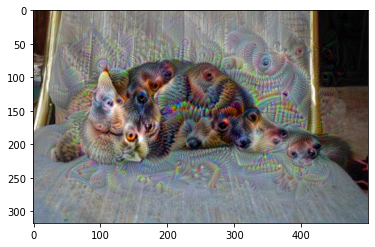

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

In [ ]:
from keras.applications import inception_v3
from keras import backend as K
K.set_learning_phase(0)
model = inception_v3.InceptionV3(weights='imagenet',
include_top=False)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
layer_contributions = {
'mixed2': 0.2,
'mixed3': 3.,
'mixed4': 2.,
'mixed5': 1.5,
}

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)
for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]
  activation = layer_dict[layer_name].output
  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [ ]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_value = outs[0]
  grad_values = outs[1]
  return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
  for i in range(iterations):
    loss_value, grad_values = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
        break
    print('...Loss value at', i, ':', loss_value)
    x += step * grad_values
  return x

In [ ]:
import numpy as np
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.
base_image_path = '/content/drive/MyDrive/Deep Dream Images/deep dreamimages/bwp1.jpg'
img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i))
  for dim in original_shape])
  successive_shapes.append(shape)
  successive_shapes = successive_shapes[::-1]
  original_img = np.copy(img)
  shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
  print('Processing image shape', shape)
  img = resize_img(img, shape)
  img = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = resize_img(original_img, shape)
  save_img(img, fname='dream_at_scale_' + str(shape) + '.png')
save_img(img, fname='final_dream.png')

Processing image shape (142, 198)
...Loss value at 0 : 0.8376771
...Loss value at 1 : 1.0880328
...Loss value at 2 : 1.5139742
...Loss value at 3 : 1.938576
...Loss value at 4 : 2.3232923
...Loss value at 5 : 2.7090237
...Loss value at 6 : 3.0261276
...Loss value at 7 : 3.4191177
...Loss value at 8 : 3.7075517
...Loss value at 9 : 4.068459
...Loss value at 10 : 4.397996
...Loss value at 11 : 4.703939
...Loss value at 12 : 5.095531
...Loss value at 13 : 5.330152
...Loss value at 14 : 5.6728964
...Loss value at 15 : 5.963724
...Loss value at 16 : 6.3101425
...Loss value at 17 : 6.6148353
...Loss value at 18 : 6.885448
...Loss value at 19 : 7.1722484
Processing image shape (280, 390)
...Loss value at 0 : 1.9405425
...Loss value at 1 : 2.8081298
...Loss value at 2 : 3.8064342
...Loss value at 3 : 4.9327273
...Loss value at 4 : 6.286199
...Loss value at 5 : 7.978461
Processing image shape (200, 278)
...Loss value at 0 : 3.389656
...Loss value at 1 : 5.3301845
...Loss value at 2 : 7.832688


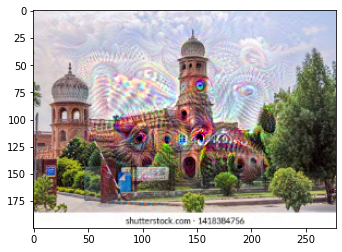

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow 

In [ ]:
import numpy as np
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.
base_image_path = '/content/drive/MyDrive/Deep Dream Images/deep dreamimages/bwp3.jpg'
img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i))
  for dim in original_shape])
  successive_shapes.append(shape)
  successive_shapes = successive_shapes[::-1]
  original_img = np.copy(img)
  shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
  print('Processing image shape', shape)
  img = resize_img(img, shape)
  img = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = resize_img(original_img, shape)
  save_img(img, fname='dream_at_scale_' + str(shape) + '.png')
save_img(img, fname='final_dream.png')

Processing image shape (435, 653)
...Loss value at 0 : 2.1245582
...Loss value at 1 : 2.61931
...Loss value at 2 : 3.2346053
...Loss value at 3 : 3.9468744
...Loss value at 4 : 4.641176
...Loss value at 5 : 5.299657
...Loss value at 6 : 5.9672
...Loss value at 7 : 6.6246533
...Loss value at 8 : 7.2445745
...Loss value at 9 : 7.8572526
...Loss value at 10 : 8.444184
...Loss value at 11 : 9.000457
...Loss value at 12 : 9.563684
Processing image shape (854, 1280)
...Loss value at 0 : 2.5447137
...Loss value at 1 : 3.3762383
...Loss value at 2 : 4.2147655
...Loss value at 3 : 5.0719438
...Loss value at 4 : 5.9295216
...Loss value at 5 : 6.775769
...Loss value at 6 : 7.588047
...Loss value at 7 : 8.383181
...Loss value at 8 : 9.143067
...Loss value at 9 : 9.8816805
Processing image shape (610, 914)
...Loss value at 0 : 4.3768697
...Loss value at 1 : 6.079646
...Loss value at 2 : 7.3184776
...Loss value at 3 : 8.316884
...Loss value at 4 : 9.235776


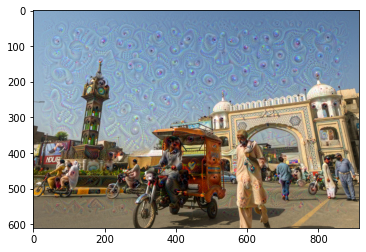

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

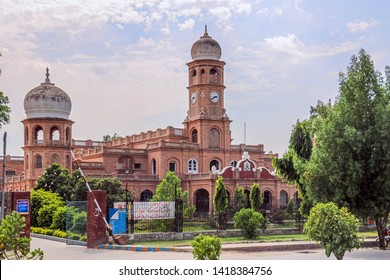

In [ ]:
rose = '/content/drive/MyDrive/Deep Dream Images/deep dreamimages/bwp1.jpg'
DIM = 224

img = image.load_img(rose, target_size=(DIM, DIM))

cv2_imshow(cv2.imread(rose)) # Visualize image

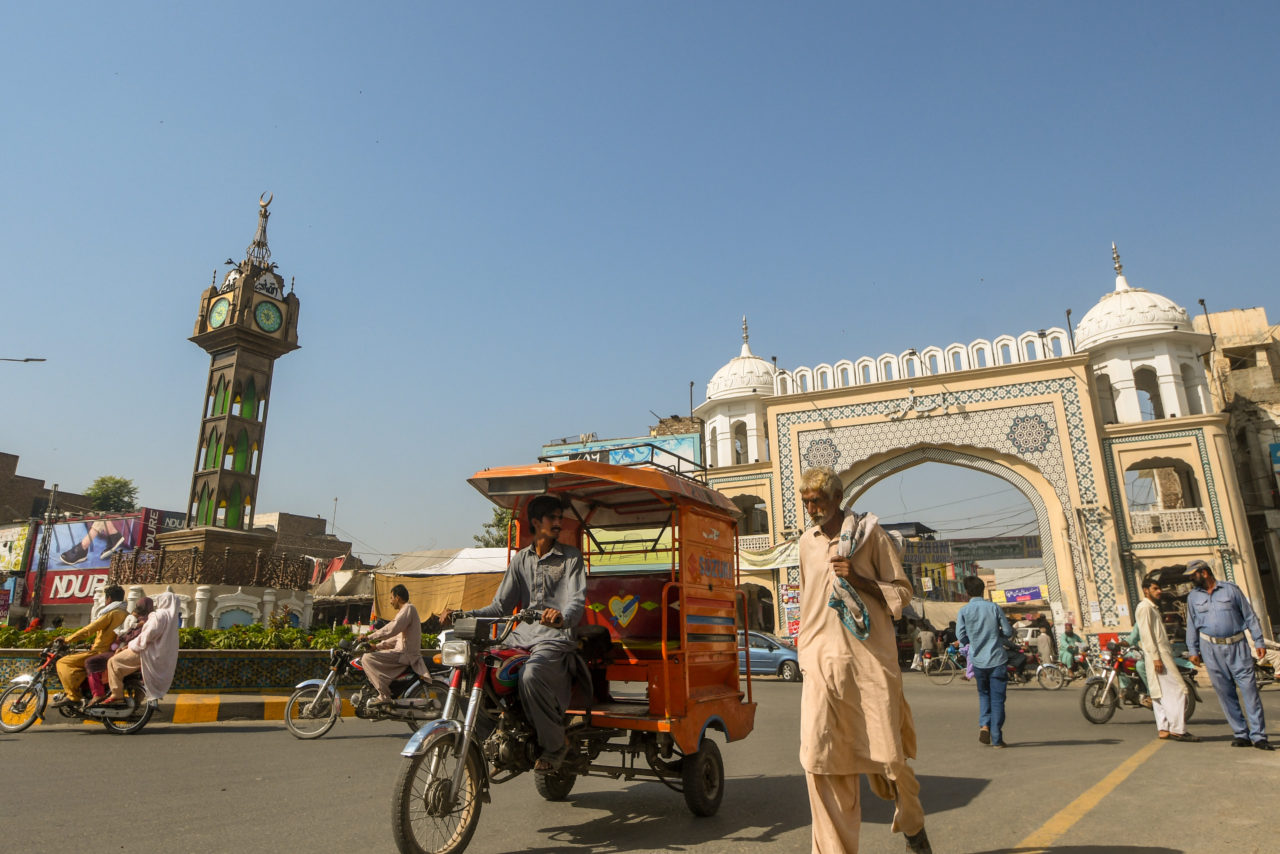

In [ ]:
rose = '/content/drive/MyDrive/Deep Dream Images/deep dreamimages/bwp3.jpg'
DIM = 40

img = image.load_img(rose, target_size=(DIM, DIM))

cv2_imshow(cv2.imread(rose)) # Visualize image

In [ ]:
import numpy as np
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.
base_image_path = '/content/drive/MyDrive/Deep Dream Images/deep dreamimages/bwp4.jpg'
img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i))
  for dim in original_shape])
  successive_shapes.append(shape)
  successive_shapes = successive_shapes[::-1]
  original_img = np.copy(img)
  shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
  print('Processing image shape', shape)
  img = resize_img(img, shape)
  img = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = resize_img(original_img, shape)
  save_img(img, fname='dream_at_scale_' + str(shape) + '.png')
save_img(img, fname='final_dream.png')

Processing image shape (244, 326)
...Loss value at 0 : 1.2063802
...Loss value at 1 : 1.7353919
...Loss value at 2 : 2.370464
...Loss value at 3 : 3.0235562
...Loss value at 4 : 3.6554515
...Loss value at 5 : 4.251695
...Loss value at 6 : 4.8630576
...Loss value at 7 : 5.4633865
...Loss value at 8 : 6.029664
...Loss value at 9 : 6.5985904
...Loss value at 10 : 7.13232
...Loss value at 11 : 7.637412
...Loss value at 12 : 8.090754
...Loss value at 13 : 8.55628
...Loss value at 14 : 8.979173
...Loss value at 15 : 9.428206
...Loss value at 16 : 9.82993
Processing image shape (480, 640)
...Loss value at 0 : 2.0559564
...Loss value at 1 : 2.881331
...Loss value at 2 : 3.715257
...Loss value at 3 : 4.5314784
...Loss value at 4 : 5.3712945
...Loss value at 5 : 6.1718063
...Loss value at 6 : 6.917139
...Loss value at 7 : 7.680516
...Loss value at 8 : 8.38389
...Loss value at 9 : 9.057106
...Loss value at 10 : 9.713577
Processing image shape (342, 457)
...Loss value at 0 : 3.1900043
...Loss valu

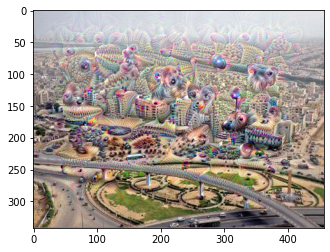

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

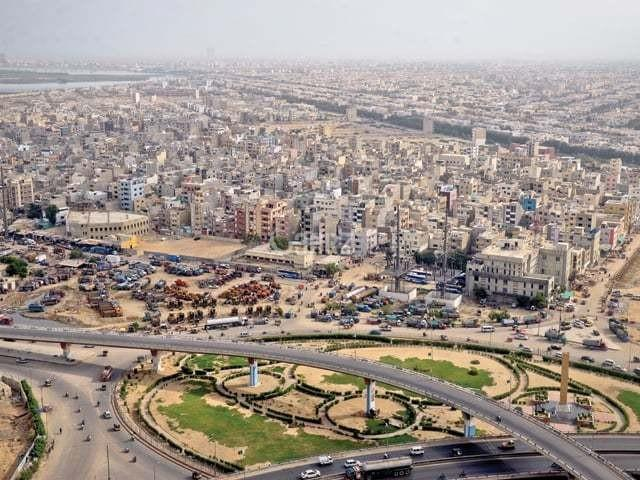

In [ ]:
rose = '/content/drive/MyDrive/Deep Dream Images/deep dreamimages/bwp4.jpg'
DIM = 180

img = image.load_img(rose, target_size=(DIM, DIM))

cv2_imshow(cv2.imread(rose)) # Visualize image

#Listing 8.13 Auxiliary functions

In [ ]:
import scipy
from keras.preprocessing import image
def resize_img(img, size):
  img = np.copy(img)
  factors = (1,
  float(size[0]) / img.shape[1],
  float(size[1]) / img.shape[2],1)
  return scipy.ndimage.zoom(img, factors, order=1)
def save_img(img, fname):
  pil_img = deprocess_image(np.copy(img))
  scipy.misc.imsave(fname, pil_img)
def preprocess_image(image_path):
  img = image.load_img(image_path)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = inception_v3.preprocess_input(img)
  return img
def deprocess_image(x):
  if K.image_data_format() == 'channels_first':
    x = x.reshape((3, x.shape[2], x.shape[3]))
    x = x.transpose((1, 2, 0))
  else:
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

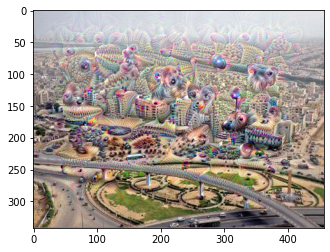

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()